In [8]:
!pip install scikeras

   ---------------------------------------- 0.0/309.1 kB ? eta -:--:--
   -------------------------- ------------- 204.8/309.1 kB 6.3 MB/s eta 0:00:01
   ---------------------------------------- 309.1/309.1 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires joblib~=1.1.0, but you have joblib 1.5.3 which is incompatible.


## Librerias

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve
)

from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier

# Opcional: solo si lo vas a usar
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False


## Exploración de los datos para su entendimiento dentro del contexto organizacional

In [12]:
ruta_base = r"D:\Cesar\Maestria Inteligencia analitica de datos\Semestre IV\Deep learning"

spam_train = pd.read_csv(ruta_base + r"\spam_train.csv")
spam_test  = pd.read_csv(ruta_base + r"\spam_test.csv")

In [14]:
print(spam_train)

        ID    V1    V2    V3   V4    V5     V6    V7    V8     V9  ...    V49  \
0      646  0.00  0.00  0.00  0.0  0.00  0.045  4.08  0.00  0.036  ...  0.000   
1     3365  0.00  0.00  0.00  0.0  0.00  0.000  0.00  0.00  0.036  ...  0.000   
2     2992  0.00  0.00  0.00  0.0  0.00  0.224  0.00  0.00  0.036  ...  0.377   
3     3885  0.00  0.19  0.59  0.0  0.19  0.000  0.00  0.00  0.226  ...  0.000   
4      818  0.23  0.34  0.58  0.0  0.46  0.233  0.11  0.23  0.036  ...  0.000   
...    ...   ...   ...   ...  ...   ...    ...   ...   ...    ...  ...    ...   
2996  4530  0.00  0.00  0.00  0.0  0.00  0.059  0.00  0.00  0.036  ...  0.000   
2997  3818  0.00  0.00  0.00  0.0  0.00  0.000  0.00  0.00  0.886  ...  0.000   
2998  4295  0.00  0.00  0.37  0.0  1.13  0.000  0.00  0.00  0.036  ...  0.000   
2999  2486  0.00  0.00  0.00  0.0  0.00  0.000  0.00  2.00  0.036  ...  0.000   
3000  1497  0.00  0.00  0.00  0.0  1.56  0.000  1.56  0.00  0.036  ...  0.000   

       V50    V51    V52   

In [18]:
import os

# Leer nombres de variables
nombres_var = pd.read_csv(
    os.path.join(ruta_base, "variable_names.txt"),
    header=None,
    sep="\t"
)

# Extraer nombres entre comillas
lista_nombres = nombres_var[0].str.extract(r'"(.*?)"')[0].tolist()

# Agregar ID al inicio
lista_nombres_final = ["ID"] + lista_nombres

# Asignar nombres
spam_train.columns = lista_nombres_final
spam_test.columns  = lista_nombres_final[:-1]

# Verificación rápida
print("Train shape:", spam_train.shape)
print("Test shape:", spam_test.shape)

spam_train.head()


Train shape: (3001, 59)
Test shape: (1600, 58)


,ID,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,SPAM
0,646,0.00,0.00,0.00,0.0,0.00,0.045,4.08,0.00,0.036,...,0.000,0.00,0.000,0.421,0.126,0.000,4.181,26,46,1
1,3365,0.00,0.00,0.00,0.0,0.00,0.000,0.00,0.00,0.036,...,0.000,0.00,0.000,0.022,0.126,0.000,1.375,6,44,0
2,2992,0.00,0.00,0.00,0.0,0.00,0.224,0.00,0.00,0.036,...,0.377,0.00,0.094,0.000,0.126,0.000,4.807,31,274,0
3,3885,0.00,0.19,0.59,0.0,0.19,0.000,0.00,0.00,0.226,...,0.000,0.00,0.018,0.000,0.126,0.000,3.716,47,472,0
4,818,0.23,0.34,0.58,0.0,0.46,0.233,0.11,0.23,0.036,...,0.000,0.46,0.000,0.376,0.182,0.018,4.470,74,675,1


=== EXPLORACIÓN DE LA BASE (SPAM) ===

Filas: 3,001 | Columnas: 59
Numéricas: 58 | Categóricas: 1
Total faltantes: 0

Distribución de SPAM:
      conteo porcentaje
SPAM                   
0       1796     59.85%
1       1205     40.15%



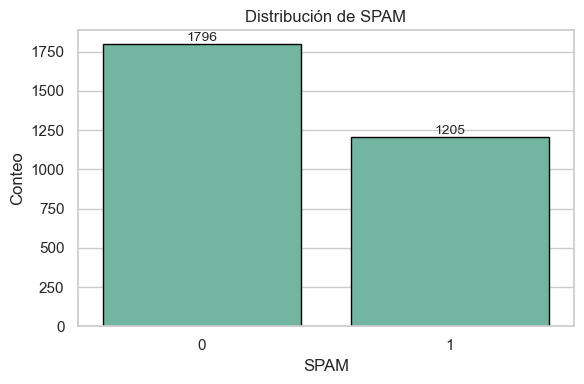

Estadísticas descriptivas (predictores numéricos) — resumen:
                         mean       std    min    25%    50%    75%     max
word_freq_make       0.098570  0.339230  0.000  0.000  0.000  0.000   6.060
word_freq_address    0.216348  1.300497  0.000  0.000  0.000  0.000  14.280
word_freq_all        0.280920  0.497393  0.000  0.000  0.000  0.430   5.100
word_freq_3d         0.088704  1.700779  0.000  0.000  0.000  0.000  42.810
word_freq_our        0.322706  0.706823  0.000  0.000  0.000  0.400  10.000
word_freq_over       0.150202  0.272827  0.000  0.000  0.054  0.192   3.609
word_freq_remove     0.112929  0.377867  0.000  0.000  0.000  0.000   7.270
word_freq_internet   0.111876  0.323354  0.000  0.000  0.000  0.000   4.340
word_freq_order      0.161871  0.556893  0.036  0.036  0.036  0.036   9.126
word_freq_mail       0.251036  0.698606  0.000  0.000  0.000  0.170  18.180
word_freq_receive    0.060780  0.204731  0.000  0.000  0.000  0.000   2.610
word_freq_will       0.5737

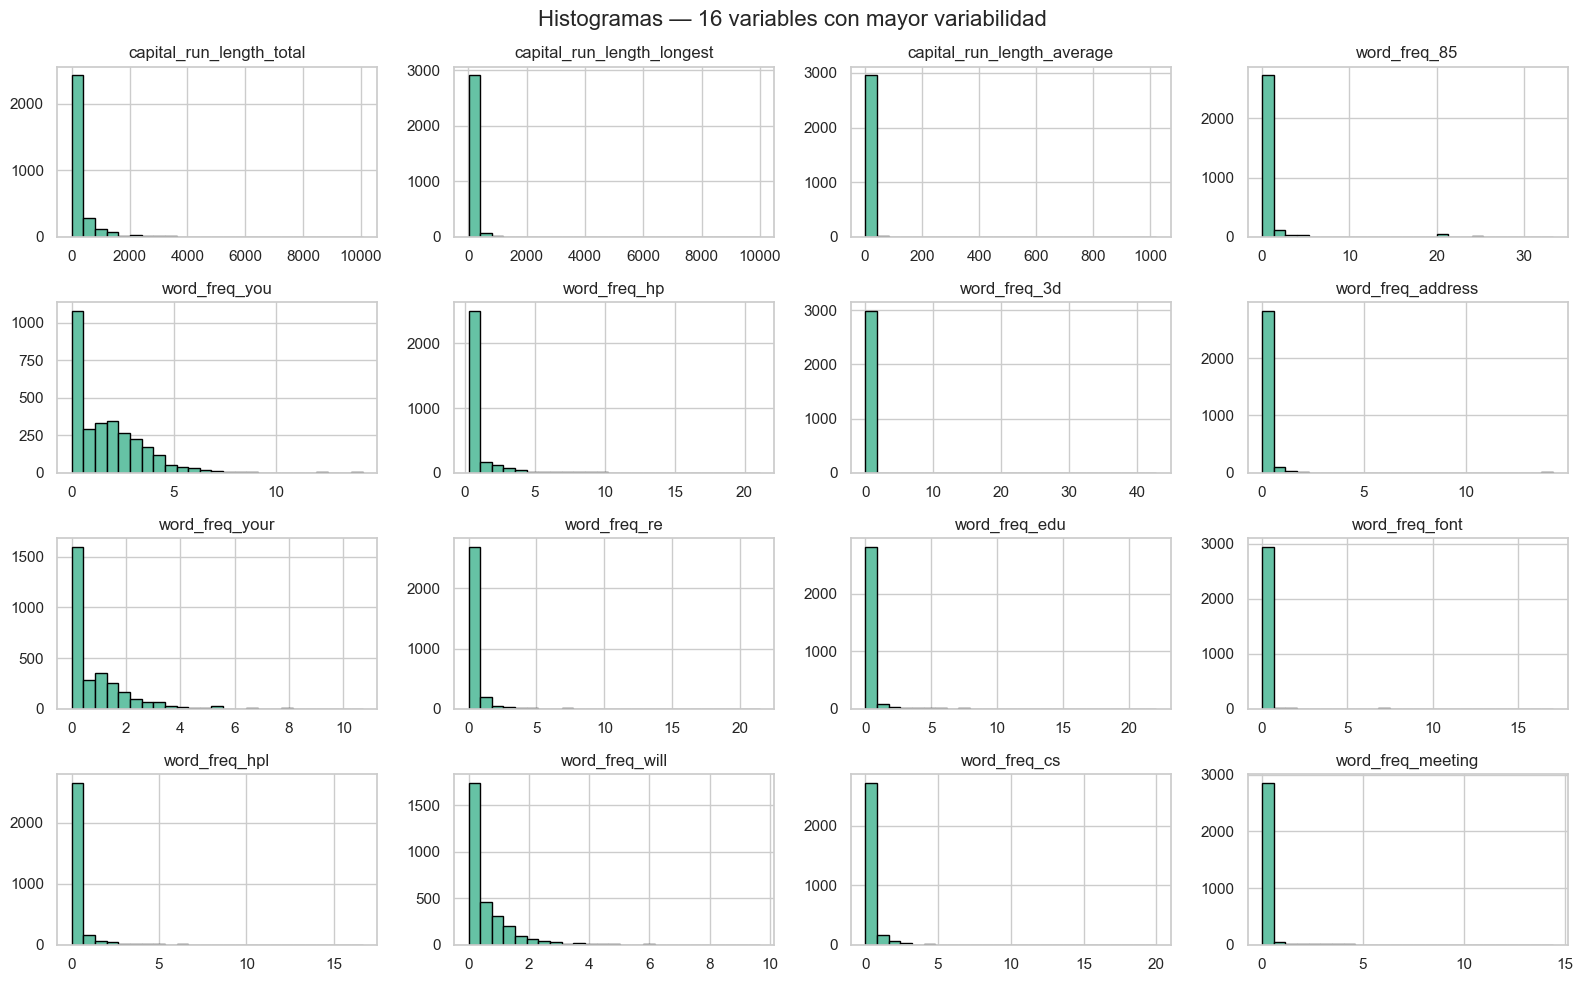

Top 10 variables más asociadas a SPAM (|corr|) para boxplots:
word_freq_your              0.3751
word_freq_remove            0.3409
word_freq_000               0.3297
char_freq_$                 0.3219
word_freq_you               0.2880
char_freq_!                 0.2718
word_freq_hp                0.2581
word_freq_business          0.2578
capital_run_length_total    0.2540
word_freq_cs                0.2388



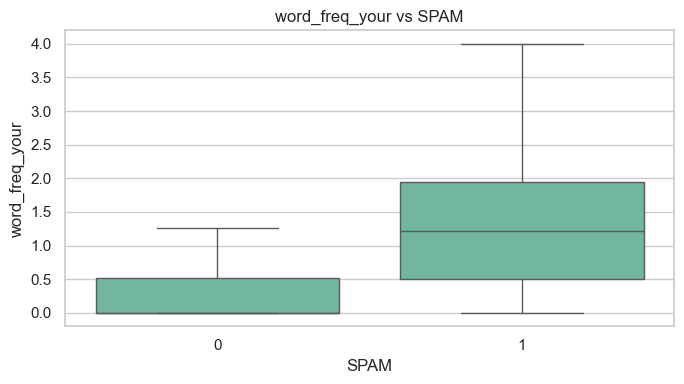

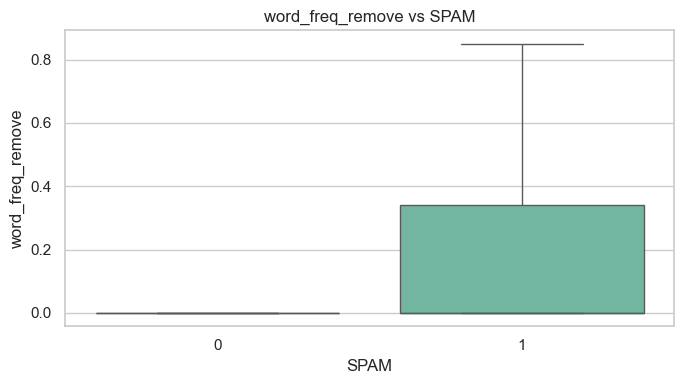

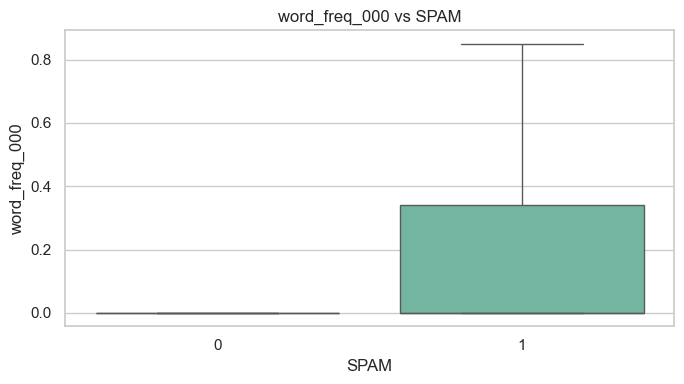

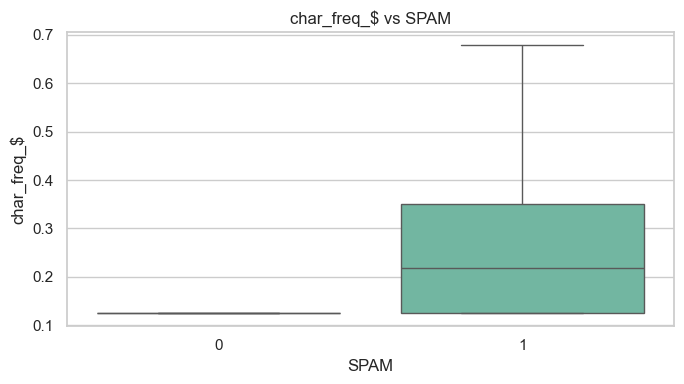

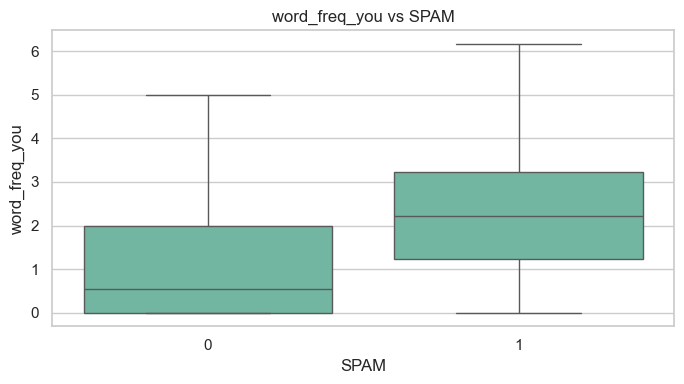

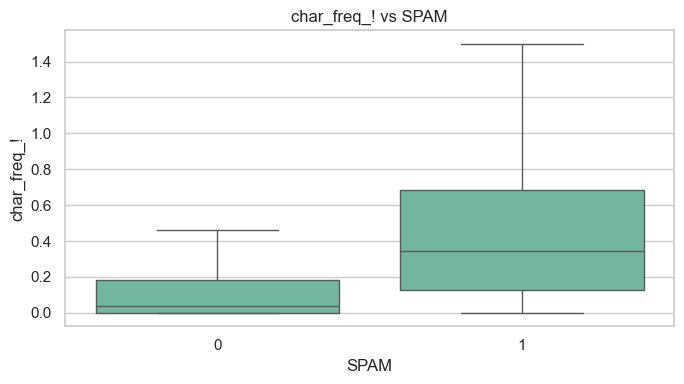

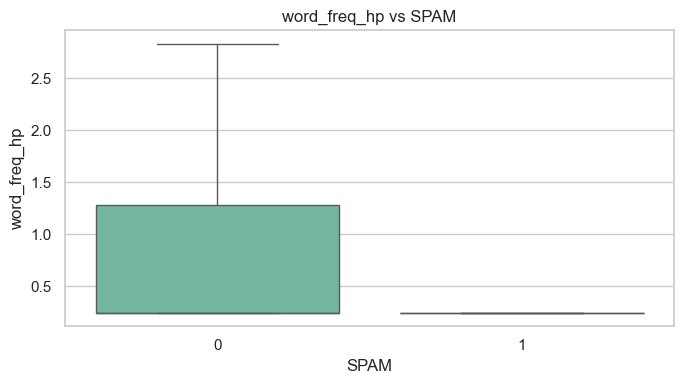

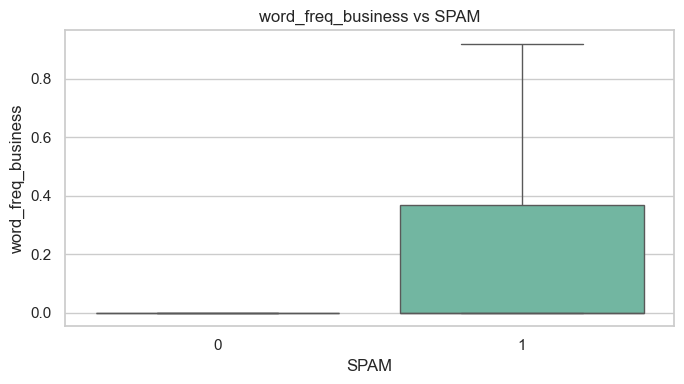

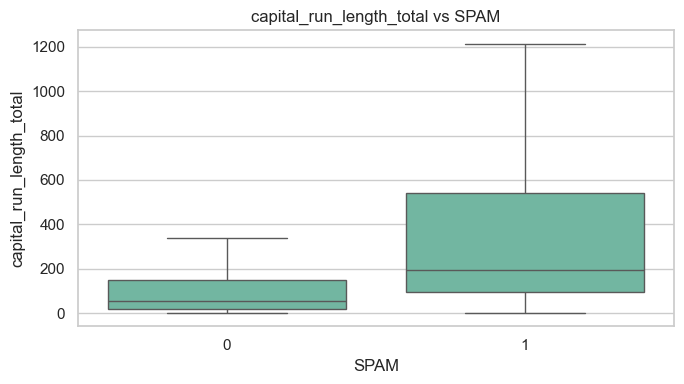

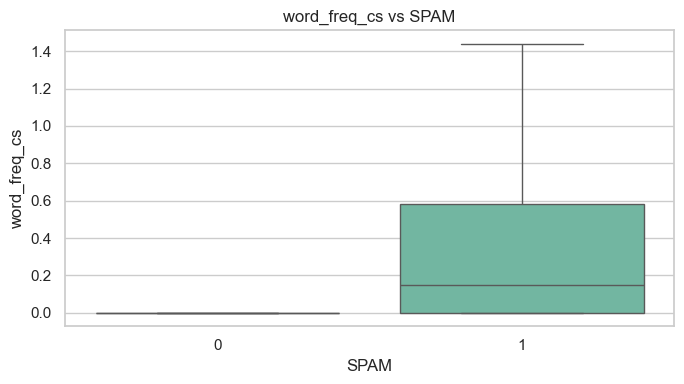

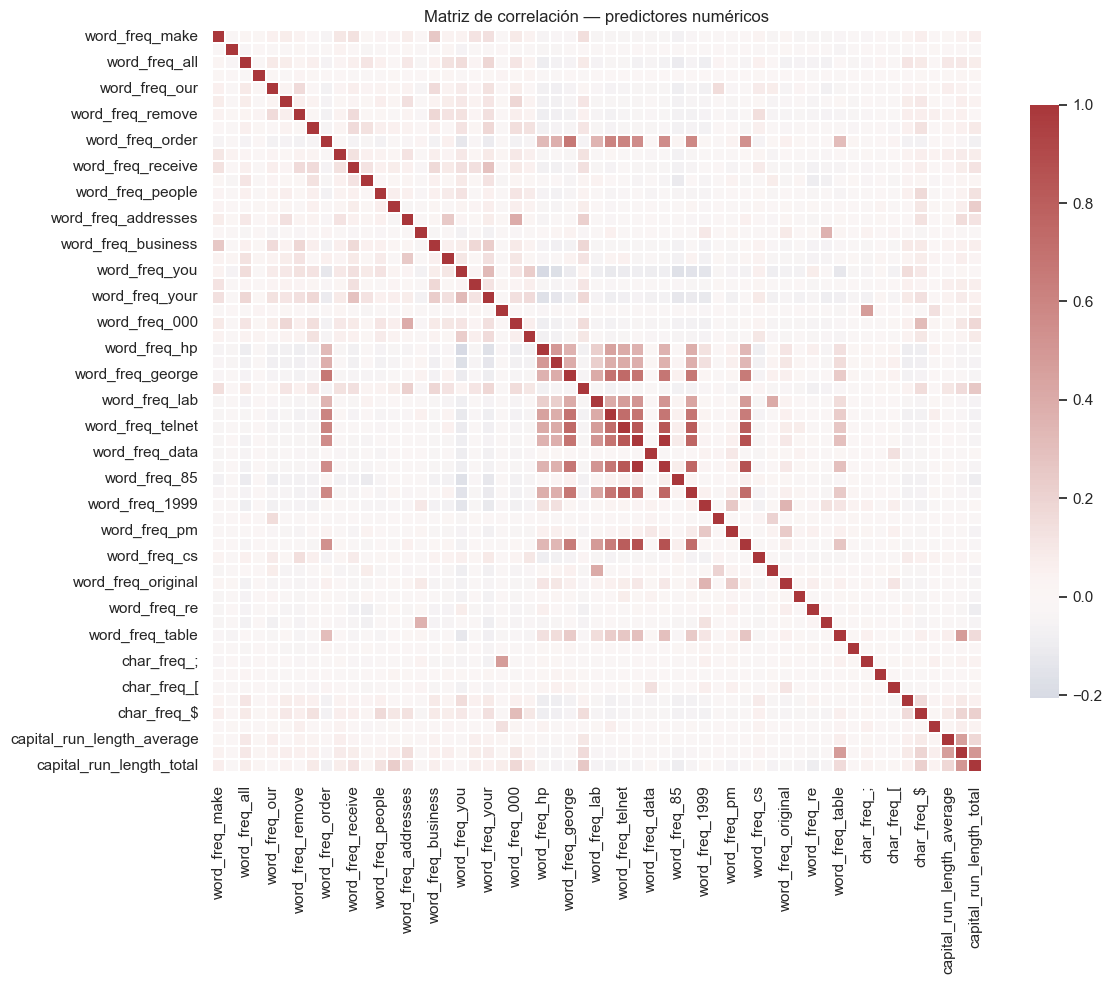


Top 12 correlaciones más altas ENTRE PREDICTORES (|r|):
- word_freq_857 ↔ word_freq_415: |r| = 0.9949
- word_freq_857 ↔ word_freq_direct: |r| = 0.8645
- word_freq_415 ↔ word_freq_direct: |r| = 0.8610
- word_freq_telnet ↔ word_freq_857: |r| = 0.8335
- word_freq_telnet ↔ word_freq_415: |r| = 0.8301
- word_freq_telnet ↔ word_freq_technology: |r| = 0.8108
- word_freq_telnet ↔ word_freq_direct: |r| = 0.8073
- word_freq_857 ↔ word_freq_technology: |r| = 0.7578
- word_freq_415 ↔ word_freq_technology: |r| = 0.7542
- word_freq_george ↔ word_freq_telnet: |r| = 0.7393
- word_freq_labs ↔ word_freq_telnet: |r| = 0.7260
- word_freq_technology ↔ word_freq_direct: |r| = 0.7190


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def explorar_spam(
    df,
    target="SPAM",
    id_col="ID",
    max_hist=16,
    max_box=10,
    top_corr_pairs=12,
    style="whitegrid",
    palette="Set2"
):
    print("=== EXPLORACIÓN DE LA BASE (SPAM) ===\n")
    df = df.copy()

    # Estilo gráfico
    sns.set_theme(style=style, palette=palette)

    # Asegurar tipos
    if id_col in df.columns:
        df[id_col] = df[id_col].astype(str).str.strip()

    if target in df.columns:
        df[target] = pd.to_numeric(df[target], errors="coerce").astype("Int64")

    # Variables numéricas
    numericas = df.select_dtypes(include=["number", "int64", "float64"]).columns.tolist()
    pred_numericas = [c for c in numericas if c != target]

    faltantes_total = df.isnull().sum().sum()
    faltantes_por_col = df.isnull().sum().sort_values(ascending=False)
    top_faltantes = faltantes_por_col[faltantes_por_col > 0].head(10)

    print(f"Filas: {df.shape[0]:,} | Columnas: {df.shape[1]:,}")
    print(f"Numéricas: {len(numericas)} | Categóricas: {df.select_dtypes(include=['object']).shape[1]}")
    print(f"Total faltantes: {int(faltantes_total):,}")

    if len(top_faltantes) > 0:
        print("\nTop columnas con faltantes:")
        print(top_faltantes.to_string())
    print()

    # ---------- Target ----------
    if target in df.columns:
        dist = df[target].value_counts(dropna=False)
        pct = (dist / len(df) * 100).round(2)

        print(f"Distribución de {target}:")
        resumen_target = pd.DataFrame({"conteo": dist, "porcentaje": pct.astype(str) + "%"})
        print(resumen_target.to_string())
        print()

        plt.figure(figsize=(6,4))
        ax = sns.countplot(x=target, data=df, edgecolor="black")
        plt.title(f"Distribución de {target}")
        plt.xlabel(target); plt.ylabel("Conteo")
        for p in ax.patches:
            ax.annotate(f"{int(p.get_height())}",
                        (p.get_x() + p.get_width()/2., p.get_height()),
                        ha="center", va="bottom", fontsize=10)
        plt.tight_layout()
        plt.show()

    # ---------- Estadísticas descriptivas ----------
    if len(pred_numericas) > 0:
        print("Estadísticas descriptivas (predictores numéricos) — resumen:")
        desc = df[pred_numericas].describe().T
        # Muestra columnas más útiles (y no 1000 cosas)
        cols_show = ["mean", "std", "min", "25%", "50%", "75%", "max"]
        print(desc[cols_show].head(15).to_string())
        if len(pred_numericas) > 15:
            print(f"\n(Se muestran 15 de {len(pred_numericas)} variables; en el anexo puedes poner la tabla completa.)")
        print()

    # Selección "inteligente" de variables para graficar:
    # - Para histogramas: las de mayor desviación estándar (más variabilidad)
    # - Para boxplots: las más correlacionadas con target (si target existe)
    cols_hist = []
    if len(pred_numericas) > 0:
        stds = df[pred_numericas].std(numeric_only=True).sort_values(ascending=False)
        cols_hist = stds.head(max_hist).index.tolist()

    # ---------- Histogramas ----------
    if len(cols_hist) > 0:
        df[cols_hist].hist(bins=25, figsize=(16, 10), edgecolor="black")
        plt.suptitle(f"Histogramas — {len(cols_hist)} variables con mayor variabilidad", fontsize=16)
        plt.tight_layout()
        plt.show()

    # ---------- Boxplots vs target ----------
    if target in df.columns and len(pred_numericas) > 0:
        # correlación con target (solo para seleccionar)
        tmp = df[[target] + pred_numericas].dropna()
        corr_to_target = tmp[pred_numericas].corrwith(tmp[target]).abs().sort_values(ascending=False)
        cols_box = corr_to_target.head(max_box).index.tolist()

        print(f"Top {len(cols_box)} variables más asociadas a {target} (|corr|) para boxplots:")
        print(corr_to_target.head(max_box).round(4).to_string())
        print()

        for col in cols_box:
            plt.figure(figsize=(7, 4))
            sns.boxplot(x=target, y=col, data=df, showfliers=False)
            plt.title(f"{col} vs {target}")
            plt.xlabel(target); plt.ylabel(col)
            plt.tight_layout()
            plt.show()

    # ---------- Correlación (heatmap legible) ----------
    if len(pred_numericas) >= 2:
        corr = df[pred_numericas].corr()

        plt.figure(figsize=(12, 10))
        sns.heatmap(
            corr,
            cmap="vlag",
            center=0,
            linewidths=0.2,
            cbar_kws={"shrink": 0.8}
        )
        plt.title("Matriz de correlación — predictores numéricos")
        plt.tight_layout()
        plt.show()

        # Top correlaciones entre predictores
        mask = np.triu(np.ones(corr.shape), k=1).astype(bool)
        top_pairs = (
            corr.where(mask).abs().stack().sort_values(ascending=False).head(top_corr_pairs)
        )

        print(f"\nTop {len(top_pairs)} correlaciones más altas ENTRE PREDICTORES (|r|):")
        for (v1, v2), val in top_pairs.items():
            print(f"- {v1} ↔ {v2}: |r| = {val:.4f}")
    else:
        print("No hay suficientes variables numéricas para un correlograma.")

# Uso
explorar_spam(spam_train)


En la etapa exploratoria se revisó la base de entrenamiento, conformada por 3.001 observaciones y 59 variables, con el objetivo de entender su estructura y validar su calidad. En esta revisión inicial no se identificaron valores faltantes y se confirmó que las variables predictoras son numéricas, lo cual facilita directamente su uso en modelos como redes neuronales (previo escalado). La variable objetivo muestra un reparto relativamente equilibrado: 1.796 correos legítimos (59,85%) frente a 1.205 correos spam (40,15%). Esta proporción evita un desbalance severo y permite evaluar los modelos sin que la clase mayoritaria domine por completo el desempeño.

Al analizar la distribución de los predictores, se observa un comportamiento típico de variables basadas en frecuencias: en muchas columnas la mediana es cero y la distribución está fuertemente sesgada a la derecha. En otras palabras, la mayoría de correos no incluyen ciertas palabras o caracteres, pero cuando aparecen, pueden hacerlo con intensidades muy distintas. Este patrón también se refleja en las variables asociadas al uso de mayúsculas, donde se evidencian valores extremos; por ejemplo, capital_run_length_longest alcanza un máximo de 9.989, lo que sugiere la presencia de mensajes con escritura inusualmente “agresiva” o promocional.

Los boxplots por clase refuerzan esta idea: varias variables presentan valores más altos en los mensajes etiquetados como spam, particularmente algunas asociadas a lenguaje comercial y de acción como word_freq_free, word_freq_remove, word_freq_our, word_freq_all y word_freq_3d. Además, la frecuencia de caracteres como “!” y “$” tiende a incrementarse en spam, coherente con estilos de correo publicitario. Aunque en ambas clases aparecen outliers, en múltiples variables se alcanza a notar una separación visible entre distribuciones, lo cual indica señal predictiva útil.

Por último, la matriz de correlación muestra que existen predictores que se mueven casi en bloque, con correlaciones muy altas entre algunas variables (por ejemplo, word_freq_857, word_freq_415 y word_freq_direct, con valores cercanos a 0,99). Esto sugiere redundancia y colinealidad en ciertos grupos de términos. En conjunto, la exploración confirma que el dataset contiene patrones claros asociados a spam, pero también presenta asimetrías marcadas y variables parcialmente redundantes, lo que respalda el uso de modelos con capacidad de capturar relaciones no lineales y de manejar interacciones entre predictores.

## Preparación de los datos para poder utilizarlos como entrada para modelos predictivos

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1) Separar X (predictores) e y (objetivo)
df_model = spam_train.drop(columns=["ID"]).copy()

X = df_model.drop(columns=["SPAM"]).copy()
y = df_model["SPAM"].astype(int).copy()

# 2) Partición estratificada Train/Validación (70/30)
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

# 3) Versión escalada (para modelos sensibles a la escala: NN, SVM, LogReg)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

# 4) Versión sin escalar (para modelos tipo árboles)
X_train_raw = X_train.copy()
X_val_raw   = X_val.copy()

# (Opcional) verificación rápida
print("Train:", X_train.shape, "Val:", X_val.shape)
print("Balance Train:", y_train.value_counts(normalize=True).round(3).to_dict())
print("Balance Val:", y_val.value_counts(normalize=True).round(3).to_dict())

# Preparar test Kaggle (sin SPAM)
X_test = spam_test.drop(columns=["ID"]).copy()

# Versión escalada del test (si tu modelo la necesita)
X_test_scaled = scaler.transform(X_test)

# Versión raw del test (para árboles)
X_test_raw = X_test.copy()

Train: (2100, 57) Val: (901, 57)
Balance Train: {0: 0.599, 1: 0.401}
Balance Val: {0: 0.598, 1: 0.402}


En la etapa de alistamiento de la información se procedió primero a retirar la variable ID, ya que su función es únicamente identificadora y no aporta capacidad explicativa para la predicción. A continuación, se definieron las matrices de entrada (X) y la variable respuesta (y), donde esta última señala si el mensaje corresponde o no a spam.

Posteriormente, la base se particionó en conjuntos de entrenamiento (70%) y validación (30%) mediante un muestreo estratificado. Con este enfoque se mantiene la proporción original de correos spam y no spam (cercana a 60%–40%) en ambos subconjuntos, lo que ayuda a obtener evaluaciones más confiables y comparables entre modelos.

Adicionalmente, se construyeron dos versiones del conjunto de predictores. Por un lado, se generó una versión estandarizada utilizando StandardScaler, que centra las variables en media cero y varianza unitaria, transformación especialmente conveniente para algoritmos sensibles a la escala como la regresión logística, las máquinas de soporte vectorial y las redes neuronales. Por otro lado, se conservó una versión sin transformar, pensada para métodos basados en árboles (por ejemplo, Random Forest y XGBoost), los cuales no dependen del escalamiento de las variables. Con esto se buscó que cada familia de modelos se entrenara bajo condiciones acordes con sus supuestos.

## Análisis preliminar de selección de modelos relevantes para responder a la pregunta

El problema propuesto se enmarca en una tarea de clasificación binaria supervisada cuyo propósito es identificar si un correo electrónico debe catalogarse como spam. La base disponible está compuesta por variables numéricas que cuantifican la presencia relativa de palabras, símbolos y patrones de uso de mayúsculas dentro de los mensajes. Considerando que se trabaja con datos tabulares de dimensión intermedia (57 predictores), resulta conveniente explorar algoritmos que no solo separen adecuadamente dos clases, sino que también tengan capacidad para representar relaciones potencialmente complejas entre las variables. Desde la perspectiva operativa, el modelo seleccionado debe ofrecer un buen equilibrio entre precisión y estabilidad, dado que errores en la clasificación pueden traducirse en filtrado ineficiente o pérdida de mensajes legítimos.

Como referencia inicial se incorpora la regresión logística, la cual funciona como modelo base por su sencillez, interpretabilidad y bajo costo computacional. Este enfoque permite establecer un punto de comparación claro frente a métodos más sofisticados. Sin embargo, dado que el comportamiento del spam suele involucrar patrones no lineales en las frecuencias de términos y caracteres, se consideran también modelos de mayor flexibilidad como Support Vector Machine, Random Forest y XGBoost. Estos algoritmos son capaces de construir fronteras de decisión más complejas y de capturar interacciones entre predictores, lo que suele traducirse en mejoras de desempeño en problemas de clasificación con datos estructurados.

Adicionalmente, se evalúan redes neuronales multicapa (MLP) debido a su capacidad para aproximar funciones altamente no lineales y aprender representaciones internas de los datos. Aunque su entrenamiento exige mayor cuidado en la calibración de hiperparámetros y sacrifica parte de la interpretabilidad, su inclusión permite contrastar enfoques tradicionales frente a técnicas de aprendizaje profundo. En conjunto, la estrategia planteada busca realizar una comparación integral que permita identificar el modelo con mejor balance entre capacidad predictiva, robustez y factibilidad de uso en un sistema automatizado de detección de correos spam.

## Desarrollo y calibración de modelos

### REGRESIÓN LOGÍSTICA

Fitting 5 folds for each of 20 candidates, totalling 100 fits

===== RESULTADOS CV =====
Mejor AUC (CV): 0.9684
Mejores hiperparámetros: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l1'}

===== VALIDACIÓN (umbral = 0.50) =====
AUC: 0.9731
Accuracy: 0.9323
Precision: 0.9101
Recall: 0.9227
F1: 0.9163

Matriz de confusión:
 [[506  33]
 [ 28 334]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.94       539
           1       0.91      0.92      0.92       362

    accuracy                           0.93       901
   macro avg       0.93      0.93      0.93       901
weighted avg       0.93      0.93      0.93       901


===== UMBRAL OPTIMIZADO PARA F1 =====
Mejor umbral: 0.47
F1: 0.9214
Precision: 0.9043
Recall: 0.9392


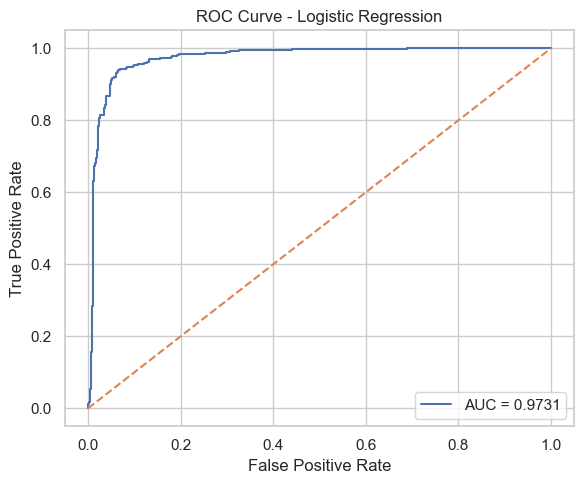

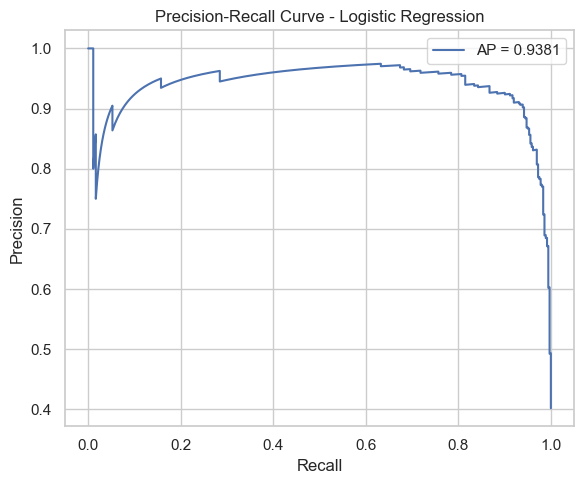

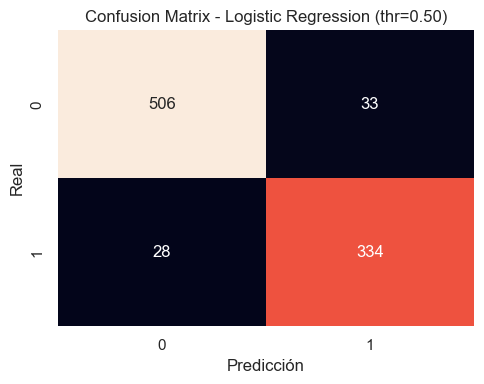


✅ Archivo generado: submission_logreg.csv
     ID      SPAM
0  1147  0.489978
1  2299  0.006449
2  2839  0.871800
3    52  0.999997
4  4507  0.001637


In [39]:
# ============================================================
# LOGISTIC REGRESSION (desde TU split y tus X_train_scaled/X_val_scaled)
# Evita TerminatedWorkerError (Windows) + métricas + ROC + PR + submission
# ============================================================

import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, average_precision_score
)

sns.set_theme(style="whitegrid")

# ------------------------------------------------------------
# A) GridSearchCV sobre datos YA escalados (X_train_scaled)
# ------------------------------------------------------------

# Modelo base
logreg = LogisticRegression(
    max_iter=8000,
    solver="saga",      # soporta l1/l2 y suele ser estable
    random_state=42
)

# Grid
param_grid = {
    "penalty": ["l2", "l1"],
    "C": [0.01, 0.1, 1, 10, 30],
    "class_weight": [None, "balanced"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=1,     # CLAVE en Windows para evitar TerminatedWorkerError
    verbose=1
)

grid.fit(X_train_scaled, y_train)

best_model = grid.best_estimator_
print("\n===== RESULTADOS CV =====")
print("Mejor AUC (CV):", round(grid.best_score_, 4))
print("Mejores hiperparámetros:", grid.best_params_)

# ------------------------------------------------------------
# B) Evaluación en validación (usando X_val_scaled)
# ------------------------------------------------------------

y_prob = best_model.predict_proba(X_val_scaled)[:, 1]
y_pred_05 = (y_prob >= 0.5).astype(int)

auc = roc_auc_score(y_val, y_prob)
acc = accuracy_score(y_val, y_pred_05)
prec = precision_score(y_val, y_pred_05, zero_division=0)
rec = recall_score(y_val, y_pred_05, zero_division=0)
f1 = f1_score(y_val, y_pred_05, zero_division=0)
cm = confusion_matrix(y_val, y_pred_05)

print("\n===== VALIDACIÓN (umbral = 0.50) =====")
print("AUC:", round(auc, 4))
print("Accuracy:", round(acc, 4))
print("Precision:", round(prec, 4))
print("Recall:", round(rec, 4))
print("F1:", round(f1, 4))
print("\nMatriz de confusión:\n", cm)
print("\nClassification Report:\n", classification_report(y_val, y_pred_05, zero_division=0))

# ------------------------------------------------------------
# C) Umbral optimizado para F1 (opcional, queda bien en informe)
# ------------------------------------------------------------

thresholds = np.arange(0.05, 0.96, 0.01)
f1s = [f1_score(y_val, (y_prob >= t).astype(int), zero_division=0) for t in thresholds]
best_t = float(thresholds[int(np.argmax(f1s))])
y_pred_bt = (y_prob >= best_t).astype(int)

print("\n===== UMBRAL OPTIMIZADO PARA F1 =====")
print("Mejor umbral:", round(best_t, 2))
print("F1:", round(f1_score(y_val, y_pred_bt, zero_division=0), 4))
print("Precision:", round(precision_score(y_val, y_pred_bt, zero_division=0), 4))
print("Recall:", round(recall_score(y_val, y_pred_bt, zero_division=0), 4))

# ------------------------------------------------------------
# D) Gráficas: ROC + PR + Confusion Matrix
# ------------------------------------------------------------

# ROC
fpr, tpr, _ = roc_curve(y_val, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.tight_layout()
plt.show()

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_val, y_prob)
ap = average_precision_score(y_val, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"AP = {ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Logistic Regression")
plt.legend()
plt.tight_layout()
plt.show()

# Confusion Matrix (heatmap)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.title("Confusion Matrix - Logistic Regression (thr=0.50)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# E) Submission Kaggle (probabilidades)
#    Ajusta el nombre de la columna si Kaggle pide otro (ej: 'target')
# ------------------------------------------------------------

test_prob = best_model.predict_proba(X_test_scaled)[:, 1]

submission = pd.DataFrame({
    "ID": spam_test["ID"],
    "SPAM": test_prob
})

submission.to_csv("submission_logreg.csv", index=False)
print("\n Archivo generado: submission_logreg.csv")
print(submission.head())


### SVM

Fitting 5 folds for each of 24 candidates, totalling 120 fits

===== RESULTADOS CV =====
Mejor AUC (CV): 0.9677
Mejores hiperparámetros: {'C': 10, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}

===== VALIDACIÓN (umbral = 0.50) =====
AUC: 0.9723
Accuracy: 0.9334
Precision: 0.9339
Recall: 0.8978
F1: 0.9155

Matriz de confusión:
 [[516  23]
 [ 37 325]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9331    0.9573    0.9451       539
           1     0.9339    0.8978    0.9155       362

    accuracy                         0.9334       901
   macro avg     0.9335    0.9276    0.9303       901
weighted avg     0.9334    0.9334    0.9332       901


===== UMBRAL OPTIMIZADO PARA F1 =====
Mejor umbral: 0.42
F1: 0.9188
Precision: 0.9318
Recall: 0.9061


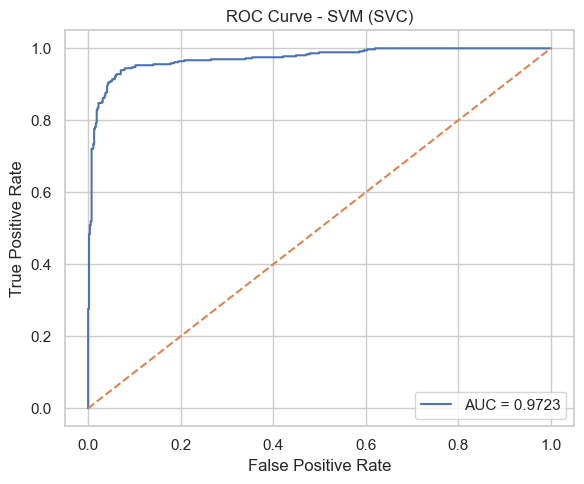

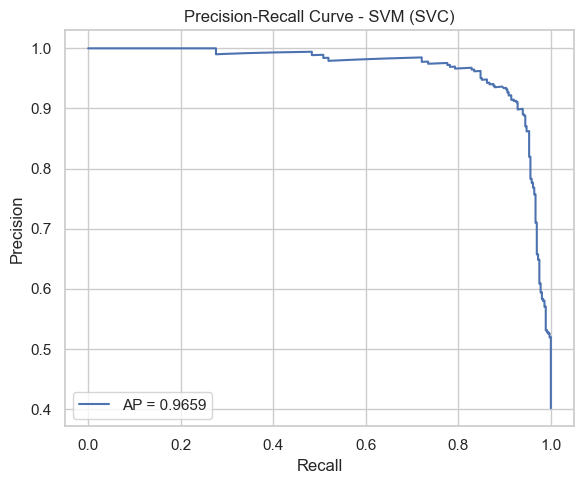

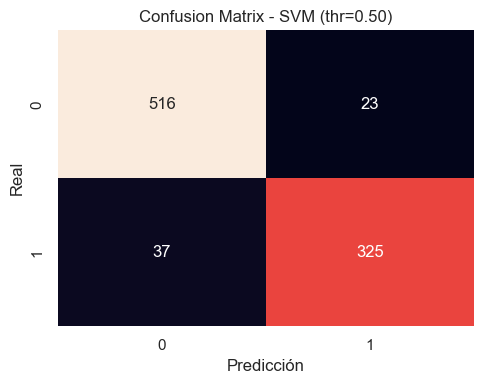


✅ Archivo generado: submission_svm.csv
     ID      SPAM
0  1147  0.185688
1  2299  0.002092
2  2839  0.869482
3    52  0.976347
4  4507  0.000100


In [43]:
# ============================================================
# SVM (SVC) - desde TU split y tus X_train_scaled/X_val_scaled
# GridSearchCV + métricas + ROC + PR + submission (si quieres)
# ============================================================

import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, average_precision_score
)

sns.set_theme(style="whitegrid")

# ------------------------------------------------------------
# A) GridSearchCV sobre datos YA escalados (X_train_scaled)
#    (SVM lo requiere, tú ya lo tienes hecho con StandardScaler)
# ------------------------------------------------------------

svm = SVC(
    probability=True,   # para predict_proba (ojo: es más lento)
    random_state=42
)

param_grid = {
    "kernel": ["linear", "rbf"],
    "C": [0.1, 1, 10],
    "gamma": ["scale", "auto"],        # solo aplica de verdad a rbf
    "class_weight": [None, "balanced"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=1,        # CLAVE en Windows para evitar TerminatedWorkerError
    verbose=1
)

grid.fit(X_train_scaled, y_train)

best_model = grid.best_estimator_
print("\n===== RESULTADOS CV =====")
print("Mejor AUC (CV):", round(grid.best_score_, 4))
print("Mejores hiperparámetros:", grid.best_params_)

# ------------------------------------------------------------
# B) Evaluación en validación (X_val_scaled)
# ------------------------------------------------------------

y_prob = best_model.predict_proba(X_val_scaled)[:, 1]
y_pred_05 = (y_prob >= 0.5).astype(int)

auc = roc_auc_score(y_val, y_prob)
acc = accuracy_score(y_val, y_pred_05)
prec = precision_score(y_val, y_pred_05, zero_division=0)
rec = recall_score(y_val, y_pred_05, zero_division=0)
f1 = f1_score(y_val, y_pred_05, zero_division=0)
cm = confusion_matrix(y_val, y_pred_05)

print("\n===== VALIDACIÓN (umbral = 0.50) =====")
print("AUC:", round(auc, 4))
print("Accuracy:", round(acc, 4))
print("Precision:", round(prec, 4))
print("Recall:", round(rec, 4))
print("F1:", round(f1, 4))
print("\nMatriz de confusión:\n", cm)
print("\nClassification Report:\n", classification_report(y_val, y_pred_05, digits=4, zero_division=0))

# ------------------------------------------------------------
# C) Umbral optimizado para F1 (opcional)
# ------------------------------------------------------------

thresholds = np.arange(0.05, 0.96, 0.01)
f1s = [f1_score(y_val, (y_prob >= t).astype(int), zero_division=0) for t in thresholds]
best_t = float(thresholds[int(np.argmax(f1s))])
y_pred_bt = (y_prob >= best_t).astype(int)

print("\n===== UMBRAL OPTIMIZADO PARA F1 =====")
print("Mejor umbral:", round(best_t, 2))
print("F1:", round(f1_score(y_val, y_pred_bt, zero_division=0), 4))
print("Precision:", round(precision_score(y_val, y_pred_bt, zero_division=0), 4))
print("Recall:", round(recall_score(y_val, y_pred_bt, zero_division=0), 4))

# ------------------------------------------------------------
# D) Gráficas: ROC + PR + Confusion Matrix
# ------------------------------------------------------------

# ROC
fpr, tpr, _ = roc_curve(y_val, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVM (SVC)")
plt.legend()
plt.tight_layout()
plt.show()

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_val, y_prob)
ap = average_precision_score(y_val, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"AP = {ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - SVM (SVC)")
plt.legend()
plt.tight_layout()
plt.show()

# Confusion Matrix (heatmap)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.title("Confusion Matrix - SVM (thr=0.50)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# E) Submission Kaggle (si lo necesitas)
#    OJO: SVM con probability=True puede ser lento para predecir test
# ------------------------------------------------------------

test_prob = best_model.predict_proba(X_test_scaled)[:, 1]

submission_svm = pd.DataFrame({
    "ID": spam_test["ID"],
    "SPAM": test_prob
})

# Guarda en la carpeta del proyecto si quieres:
# import os
# ruta_salida = r"D:\Cesar\Maestria Inteligencia analitica de datos\Semestre IV\Deep learning"
# submission_svm.to_csv(os.path.join(ruta_salida, "submission_svm.csv"), index=False)

submission_svm.to_csv("submission_svm.csv", index=False)
print("\n✅ Archivo generado: submission_svm.csv")
print(submission_svm.head())


### Random Forest

Fitting 5 folds for each of 96 candidates, totalling 480 fits

===== RESULTADOS CV =====
Mejor AUC (CV): 0.9807
Mejores hiperparámetros: {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 600}

===== VALIDACIÓN (umbral = 0.50) =====
AUC: 0.982
Accuracy: 0.9478
Precision: 0.9592
Recall: 0.9088
F1: 0.9333

Matriz de confusión:
 [[525  14]
 [ 33 329]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9409    0.9740    0.9572       539
           1     0.9592    0.9088    0.9333       362

    accuracy                         0.9478       901
   macro avg     0.9500    0.9414    0.9452       901
weighted avg     0.9482    0.9478    0.9476       901


===== UMBRAL OPTIMIZADO PARA F1 =====
Mejor umbral: 0.39
F1: 0.9438
Precision: 0.9373
Recall: 0.9503


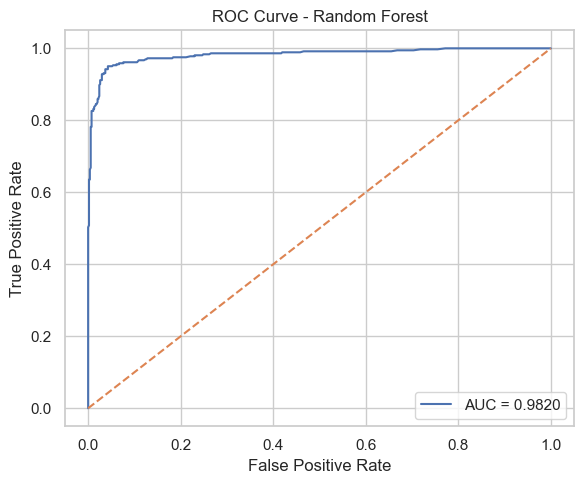

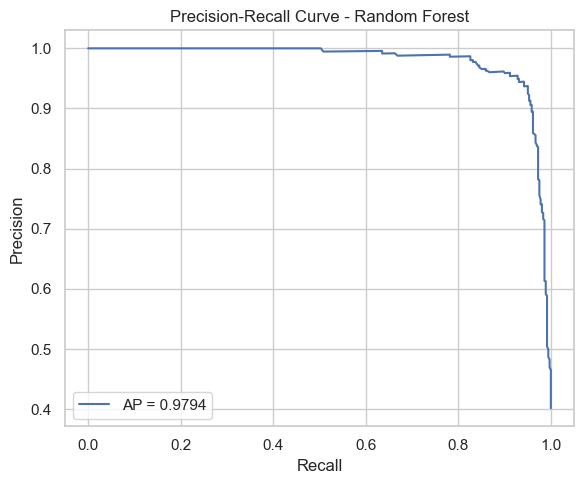

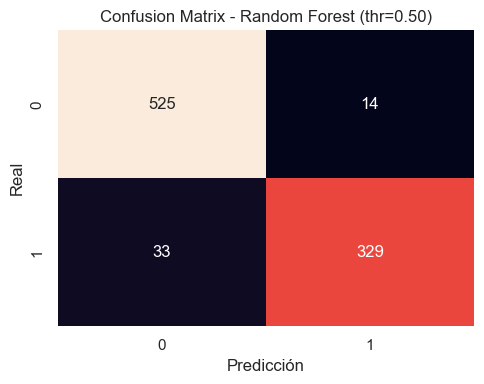


✅ Archivo generado: submission_rf.csv
     ID      SPAM
0  1147  0.556667
1  2299  0.031667
2  2839  0.768333
3    52  0.995000
4  4507  0.088333


In [45]:
# ============================================================
# RANDOM FOREST - desde TU split (X_train_raw / X_val_raw / X_test_raw)
# GridSearchCV + métricas + ROC + PR + submission
# (Windows-safe: n_jobs=1 para evitar TerminatedWorkerError)
# ============================================================

import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, average_precision_score
)

sns.set_theme(style="whitegrid")

# ------------------------------------------------------------
# A) GridSearchCV sobre datos RAW (árboles no necesitan escalado)
# ------------------------------------------------------------

rf = RandomForestClassifier(
    random_state=42,
    n_jobs=1  # threads internos del RF (déjalo en 1 para evitar líos de sobre-hilos)
)

# Grid equilibrado (calidad vs tiempo)
param_grid = {
    "n_estimators": [300, 600],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2"],
    "class_weight": [None, "balanced"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=1,      # CLAVE: evita TerminatedWorkerError en Windows
    verbose=1
)

grid.fit(X_train_raw, y_train)

best_model = grid.best_estimator_
print("\n===== RESULTADOS CV =====")
print("Mejor AUC (CV):", round(grid.best_score_, 4))
print("Mejores hiperparámetros:", grid.best_params_)

# ------------------------------------------------------------
# B) Evaluación en validación (RAW)
# ------------------------------------------------------------

y_prob = best_model.predict_proba(X_val_raw)[:, 1]
y_pred_05 = (y_prob >= 0.5).astype(int)

auc = roc_auc_score(y_val, y_prob)
acc = accuracy_score(y_val, y_pred_05)
prec = precision_score(y_val, y_pred_05, zero_division=0)
rec = recall_score(y_val, y_pred_05, zero_division=0)
f1 = f1_score(y_val, y_pred_05, zero_division=0)
cm = confusion_matrix(y_val, y_pred_05)

print("\n===== VALIDACIÓN (umbral = 0.50) =====")
print("AUC:", round(auc, 4))
print("Accuracy:", round(acc, 4))
print("Precision:", round(prec, 4))
print("Recall:", round(rec, 4))
print("F1:", round(f1, 4))
print("\nMatriz de confusión:\n", cm)
print("\nClassification Report:\n", classification_report(y_val, y_pred_05, digits=4, zero_division=0))

# ------------------------------------------------------------
# C) Umbral optimizado para F1 (opcional)
# ------------------------------------------------------------

thresholds = np.arange(0.05, 0.96, 0.01)
f1s = [f1_score(y_val, (y_prob >= t).astype(int), zero_division=0) for t in thresholds]
best_t = float(thresholds[int(np.argmax(f1s))])
y_pred_bt = (y_prob >= best_t).astype(int)

print("\n===== UMBRAL OPTIMIZADO PARA F1 =====")
print("Mejor umbral:", round(best_t, 2))
print("F1:", round(f1_score(y_val, y_pred_bt, zero_division=0), 4))
print("Precision:", round(precision_score(y_val, y_pred_bt, zero_division=0), 4))
print("Recall:", round(recall_score(y_val, y_pred_bt, zero_division=0), 4))

# ------------------------------------------------------------
# D) Gráficas: ROC + PR + Confusion Matrix
# ------------------------------------------------------------

# ROC
fpr, tpr, _ = roc_curve(y_val, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.tight_layout()
plt.show()

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_val, y_prob)
ap = average_precision_score(y_val, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"AP = {ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Random Forest")
plt.legend()
plt.tight_layout()
plt.show()

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.title("Confusion Matrix - Random Forest (thr=0.50)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# E) Submission Kaggle (probabilidades)
# ------------------------------------------------------------

test_prob = best_model.predict_proba(X_test_raw)[:, 1]

submission_rf = pd.DataFrame({
    "ID": spam_test["ID"],
    "SPAM": test_prob
})

submission_rf.to_csv("submission_rf.csv", index=False)
print("\n✅ Archivo generado: submission_rf.csv")
print(submission_rf.head())


### XGBoost

Fitting 5 folds for each of 192 candidates, totalling 960 fits


C:\Users\USER\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:08:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\USER\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:08:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\USER\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:08:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\USER\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:08:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,


===== RESULTADOS CV =====
Mejor AUC (CV): 0.9842
Mejores hiperparámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 600, 'reg_lambda': 1.0, 'subsample': 1.0}

===== VALIDACIÓN (umbral = 0.50) =====
AUC: 0.9845
Accuracy: 0.9489
Precision: 0.9514
Recall: 0.9199
F1: 0.9354

Matriz de confusión:
 [[522  17]
 [ 29 333]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9474    0.9685    0.9578       539
           1     0.9514    0.9199    0.9354       362

    accuracy                         0.9489       901
   macro avg     0.9494    0.9442    0.9466       901
weighted avg     0.9490    0.9489    0.9488       901


===== UMBRAL OPTIMIZADO PARA F1 =====
Mejor umbral: 0.48
F1: 0.9371
Precision: 0.949
Recall: 0.9254


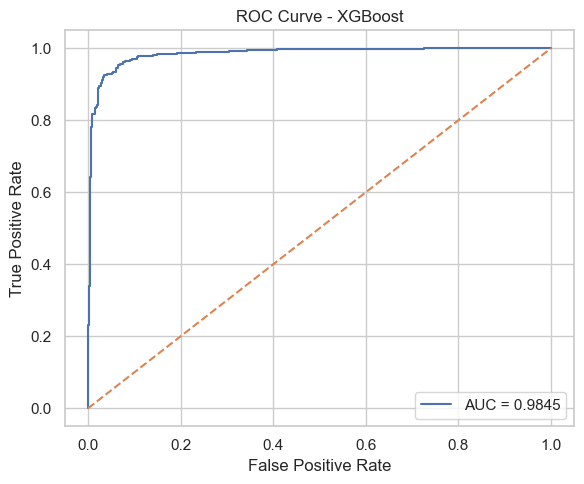

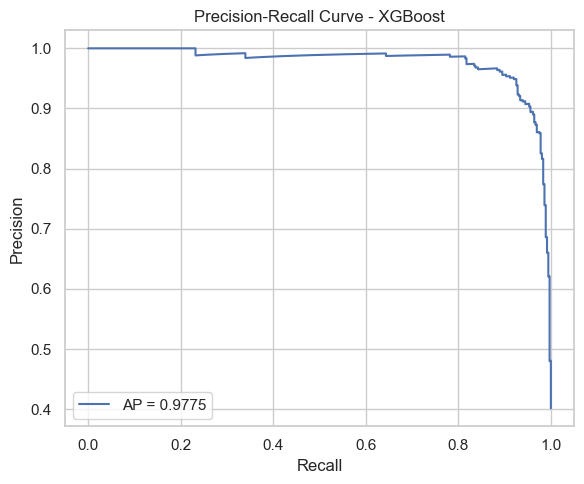

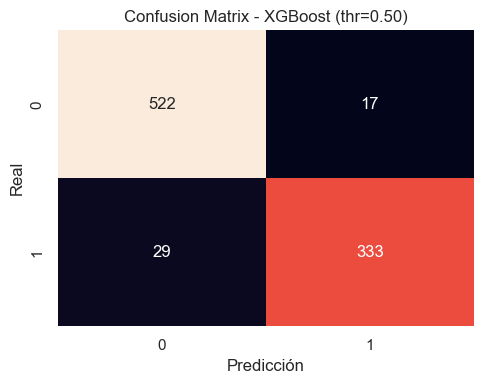


✅ Archivo generado: submission_xgb.csv
     ID      SPAM
0  1147  0.441140
1  2299  0.010106
2  2839  0.945743
3    52  0.999554
4  4507  0.014888


In [49]:
# ============================================================
# XGBOOST - desde TU split (RAW)
# ============================================================

import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, average_precision_score
)

sns.set_theme(style="whitegrid")

# ------------------------------------------------------------
# A) Limpieza robusta de nombres (XGBoost es delicado)
# ------------------------------------------------------------

def clean_feature_names(df):
    df = df.copy()
    df.columns = (
        df.columns.astype(str)
        .str.replace("[", "LBRACK", regex=False)
        .str.replace("]", "RBRACK", regex=False)
        .str.replace("<", "LT", regex=False)
        .str.replace(">", "GT", regex=False)
        .str.replace(" ", "_", regex=False)
    )
    return df

X_train_xgb = clean_feature_names(X_train_raw)
X_val_xgb   = clean_feature_names(X_val_raw)
X_test_xgb  = clean_feature_names(X_test_raw)

# ------------------------------------------------------------
# B) Modelo base
# ------------------------------------------------------------

xgb = XGBClassifier(
    random_state=42,
    eval_metric="logloss",
    tree_method="hist",
    n_jobs=1,              # IMPORTANTE en Windows
    use_label_encoder=False
)

# Grid balanceado (buena calidad sin explotar tiempo)
param_grid = {
    "n_estimators": [300, 600],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.03, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "min_child_weight": [1, 5],
    "reg_lambda": [1.0, 5.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=1,          # 🔥 evita TerminatedWorkerError
    verbose=1
)

grid.fit(X_train_xgb, y_train)

best_model = grid.best_estimator_

print("\n===== RESULTADOS CV =====")
print("Mejor AUC (CV):", round(grid.best_score_, 4))
print("Mejores hiperparámetros:", grid.best_params_)

# ------------------------------------------------------------
# C) Evaluación en validación
# ------------------------------------------------------------

y_prob = best_model.predict_proba(X_val_xgb)[:, 1]
y_pred_05 = (y_prob >= 0.5).astype(int)

auc = roc_auc_score(y_val, y_prob)
acc = accuracy_score(y_val, y_pred_05)
prec = precision_score(y_val, y_pred_05, zero_division=0)
rec = recall_score(y_val, y_pred_05, zero_division=0)
f1 = f1_score(y_val, y_pred_05, zero_division=0)
cm = confusion_matrix(y_val, y_pred_05)

print("\n===== VALIDACIÓN (umbral = 0.50) =====")
print("AUC:", round(auc, 4))
print("Accuracy:", round(acc, 4))
print("Precision:", round(prec, 4))
print("Recall:", round(rec, 4))
print("F1:", round(f1, 4))
print("\nMatriz de confusión:\n", cm)
print("\nClassification Report:\n", classification_report(y_val, y_pred_05, digits=4, zero_division=0))

# ------------------------------------------------------------
# D) Umbral óptimo para F1 (bonus)
# ------------------------------------------------------------

thresholds = np.arange(0.05, 0.96, 0.01)
f1s = [f1_score(y_val, (y_prob >= t).astype(int), zero_division=0) for t in thresholds]
best_t = float(thresholds[int(np.argmax(f1s))])
y_pred_bt = (y_prob >= best_t).astype(int)

print("\n===== UMBRAL OPTIMIZADO PARA F1 =====")
print("Mejor umbral:", round(best_t, 2))
print("F1:", round(f1_score(y_val, y_pred_bt, zero_division=0), 4))
print("Precision:", round(precision_score(y_val, y_pred_bt, zero_division=0), 4))
print("Recall:", round(recall_score(y_val, y_pred_bt, zero_division=0), 4))

# ------------------------------------------------------------
# E) Gráficas (ROC + PR + CM)
# ------------------------------------------------------------

# ROC
fpr, tpr, _ = roc_curve(y_val, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.tight_layout()
plt.show()

# Precision-Recall (esto da puntos en el informe)
precision, recall, _ = precision_recall_curve(y_val, y_prob)
ap = average_precision_score(y_val, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"AP = {ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - XGBoost")
plt.legend()
plt.tight_layout()
plt.show()

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.title("Confusion Matrix - XGBoost (thr=0.50)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# F) Submission Kaggle
# ------------------------------------------------------------

test_prob = best_model.predict_proba(X_test_xgb)[:, 1]

submission_xgb = pd.DataFrame({
    "ID": spam_test["ID"],
    "SPAM": test_prob
})

submission_xgb.to_csv("submission_xgb.csv", index=False)
print("\n✅ Archivo generado: submission_xgb.csv")
print(submission_xgb.head())


### Red Neuronal

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END batch_size=64, epochs=40, model__activation=tanh, model__dropout=0.3, model__l2=0.001, model__learning_rate=0.0005, model__n_hidden=1, model__units=64; total time=   9.5s
[CV] END batch_size=64, epochs=40, model__activation=tanh, model__dropout=0.3, model__l2=0.001, model__learning_rate=0.0005, model__n_hidden=1, model__units=64; total time=   7.1s
[CV] END batch_size=64, epochs=40, model__activation=tanh, model__dropout=0.3, model__l2=0.001, model__learning_rate=0.0005, model__n_hidden=1, model__units=64; total time=   7.3s
[CV] END batch_size=32, epochs=40, model__activation=relu, model__dropout=0.3, model__l2=0.0001, model__learning_rate=0.001, model__n_hidden=2, model__units=32; total time=   8.8s
[CV] END batch_size=32, epochs=40, model__activation=relu, model__dropout=0.3, model__l2=0.0001, model__learning_rate=0.001, model__n_hidden=2, model__units=32; total time=   9.4s
[CV] END batch_size=32, epochs=40, mode

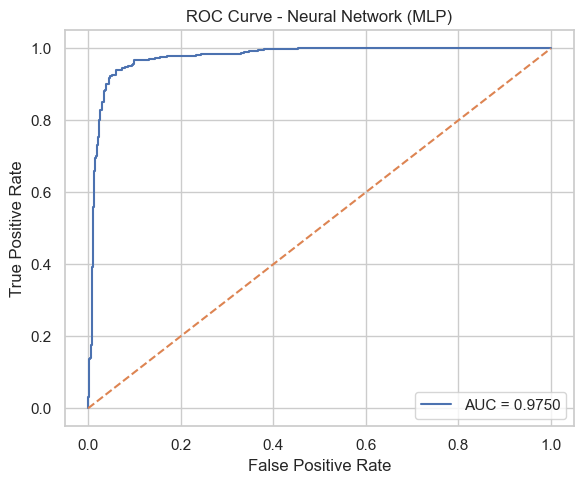

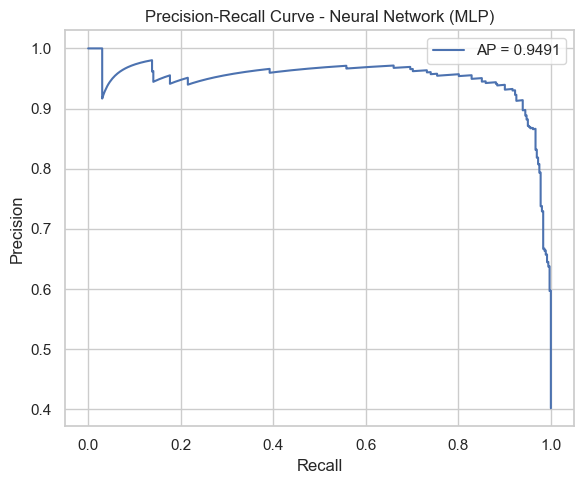

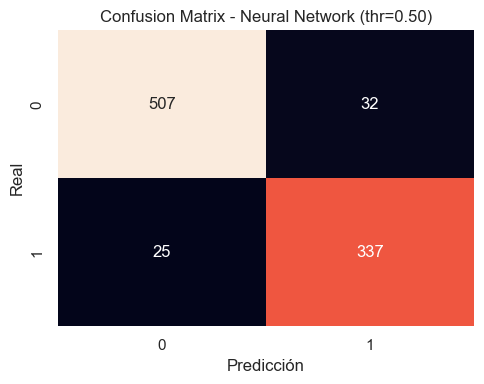


✅ Archivo generado: submission_nn.csv
     ID          SPAM
0  1147  4.924574e-01
1  2299  2.400959e-03
2  2839  8.950286e-01
3    52  9.999861e-01
4  4507  5.864789e-08


In [47]:
# ============================================================
# RED NEURONAL (MLP) - desde TU split
# Usa tus X_train_scaled / X_val_scaled / X_test_scaled (ya escalados)
# RandomizedSearchCV (SciKeras) + EarlyStopping + métricas + ROC + PR + submission
# ============================================================

import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
# Reduce logs de TF (opcional)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, average_precision_score
)

sns.set_theme(style="whitegrid")

# ------------------------------------------------------------
# A) Asegurar y en formato binario int
# ------------------------------------------------------------
y_train_int = np.asarray(y_train).astype(int)
y_val_int   = np.asarray(y_val).astype(int)

tf.random.set_seed(42)
np.random.seed(42)

n_features = X_train_scaled.shape[1]  # usa el array escalado

# ------------------------------------------------------------
# B) Builder del modelo (MLP)
# ------------------------------------------------------------
def build_model(
    n_hidden=2,
    units=64,
    activation="relu",
    learning_rate=1e-3,
    l2=1e-4,
    dropout=0.2
):
    model = keras.Sequential()
    model.add(layers.Input(shape=(n_features,)))

    for _ in range(n_hidden):
        model.add(layers.Dense(
            units,
            activation=activation,
            kernel_regularizer=regularizers.l2(l2)
        ))
        if dropout and dropout > 0:
            model.add(layers.Dropout(dropout))

    model.add(layers.Dense(1, activation="sigmoid"))

    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=opt,
        loss="binary_crossentropy",
        metrics=[keras.metrics.AUC(name="auc"), "accuracy"]
    )
    return model

# Wrapper SciKeras
keras_clf = KerasClassifier(
    model=build_model,
    verbose=0
)

# ------------------------------------------------------------
# C) Búsqueda aleatoria (tuning)
#    OJO: ya estás escalando por fuera, así que NO usamos Pipeline con scaler
# ------------------------------------------------------------
param_dist = {
    "model__n_hidden": [1, 2, 3],
    "model__units": [32, 64, 128],
    "model__activation": ["relu", "tanh"],
    "model__learning_rate": [1e-3, 5e-4],
    "model__l2": [1e-4, 1e-3],
    "model__dropout": [0.0, 0.2, 0.3],
    "batch_size": [32, 64],
    "epochs": [40]   # con early stopping no suele llegar al final
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_auc",
    mode="max",
    patience=7,
    restore_best_weights=True
)

# Scorer AUC robusto (SciKeras puede devolver (n,2) o (n,1))
def auc_scorer(estimator, X, y):
    proba = estimator.predict_proba(X)
    if proba.ndim == 2 and proba.shape[1] == 2:
        p1 = proba[:, 1]
    else:
        p1 = proba.ravel()
    return roc_auc_score(y, p1)

search = RandomizedSearchCV(
    estimator=keras_clf,
    param_distributions=param_dist,
    n_iter=20,          # 20 suele ser buen balance
    scoring=auc_scorer,
    cv=cv,
    n_jobs=1,           # importante con TF
    verbose=2,
    random_state=42,
    error_score="raise"
)

search.fit(
    X_train_scaled, y_train_int,
    callbacks=[early_stop],
    validation_split=0.15
)

print("\n===== RESULTADOS CV =====")
print("Mejor AUC (CV):", round(search.best_score_, 4))
print("Mejores hiperparámetros:", search.best_params_)

best_model = search.best_estimator_

# ------------------------------------------------------------
# D) Evaluación en validación (X_val_scaled)
# ------------------------------------------------------------
y_prob_full = best_model.predict_proba(X_val_scaled)
y_prob = y_prob_full[:, 1] if (y_prob_full.ndim == 2 and y_prob_full.shape[1] == 2) else y_prob_full.ravel()
y_pred_05 = (y_prob >= 0.5).astype(int)

auc = roc_auc_score(y_val_int, y_prob)
acc = accuracy_score(y_val_int, y_pred_05)
prec = precision_score(y_val_int, y_pred_05, zero_division=0)
rec = recall_score(y_val_int, y_pred_05, zero_division=0)
f1 = f1_score(y_val_int, y_pred_05, zero_division=0)
cm = confusion_matrix(y_val_int, y_pred_05)

print("\n===== VALIDACIÓN (umbral = 0.50) =====")
print("AUC:", round(auc, 4))
print("Accuracy:", round(acc, 4))
print("Precision:", round(prec, 4))
print("Recall:", round(rec, 4))
print("F1:", round(f1, 4))
print("\nMatriz de confusión:\n", cm)
print("\nClassification Report:\n", classification_report(y_val_int, y_pred_05, digits=4, zero_division=0))

# ------------------------------------------------------------
# E) Umbral optimizado para F1 (opcional)
# ------------------------------------------------------------
thresholds = np.arange(0.05, 0.96, 0.01)
f1s = [f1_score(y_val_int, (y_prob >= t).astype(int), zero_division=0) for t in thresholds]
best_t = float(thresholds[int(np.argmax(f1s))])
y_pred_bt = (y_prob >= best_t).astype(int)

print("\n===== UMBRAL OPTIMIZADO PARA F1 =====")
print("Mejor umbral:", round(best_t, 2))
print("F1:", round(f1_score(y_val_int, y_pred_bt, zero_division=0), 4))
print("Precision:", round(precision_score(y_val_int, y_pred_bt, zero_division=0), 4))
print("Recall:", round(recall_score(y_val_int, y_pred_bt, zero_division=0), 4))

# ------------------------------------------------------------
# F) Gráficas: ROC + PR + Confusion Matrix
# ------------------------------------------------------------

# ROC
fpr, tpr, _ = roc_curve(y_val_int, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Neural Network (MLP)")
plt.legend()
plt.tight_layout()
plt.show()

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_val_int, y_prob)
ap = average_precision_score(y_val_int, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"AP = {ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Neural Network (MLP)")
plt.legend()
plt.tight_layout()
plt.show()

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.title("Confusion Matrix - Neural Network (thr=0.50)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# G) Submission Kaggle (probabilidades)
# ------------------------------------------------------------
test_prob_full = best_model.predict_proba(X_test_scaled)
test_prob = test_prob_full[:, 1] if (test_prob_full.ndim == 2 and test_prob_full.shape[1] == 2) else test_prob_full.ravel()

submission_nn = pd.DataFrame({
    "ID": spam_test["ID"],
    "SPAM": test_prob
})

submission_nn.to_csv("submission_nn.csv", index=False)
print("\n✅ Archivo generado: submission_nn.csv")
print(submission_nn.head())


## Visualización de resultados

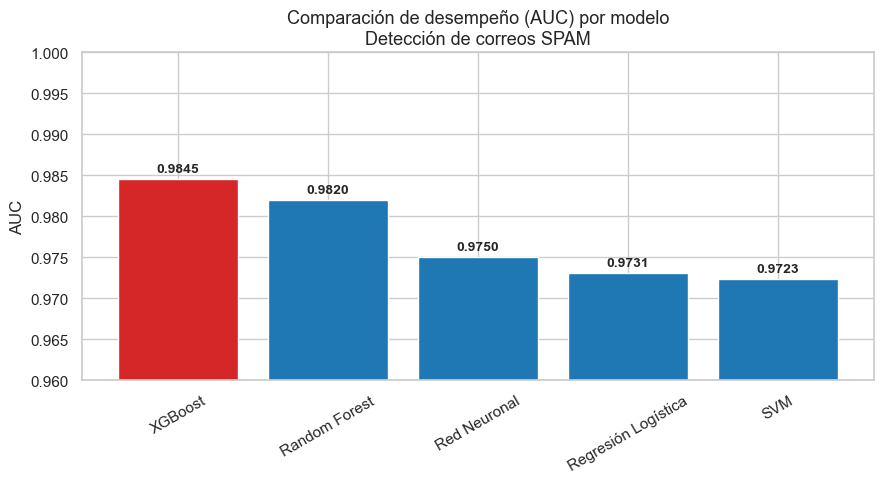

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# ------------------------------------------------------------
# Datos de desempeño
# ------------------------------------------------------------
auc_data = pd.DataFrame({
    "Modelo": [
        "Regresión Logística",
        "SVM",
        "Random Forest",
        "XGBoost",
        "Red Neuronal"
    ],
    "AUC": [
        0.9731,
        0.9723,
        0.9820,
        0.9845,
        0.9750
    ]
})

# Ordenar
auc_data = auc_data.sort_values(by="AUC", ascending=False).reset_index(drop=True)

# ------------------------------------------------------------
# Colores (resaltar el mejor)
# ------------------------------------------------------------
colors = ["#1f77b4"] * len(auc_data)
colors[0] = "#d62728"  # rojo para el mejor modelo

# ------------------------------------------------------------
# Gráfico
# ------------------------------------------------------------
plt.figure(figsize=(9,5))
bars = plt.bar(auc_data["Modelo"], auc_data["AUC"], color=colors)

plt.ylabel("AUC")
plt.title("Comparación de desempeño (AUC) por modelo\nDetección de correos SPAM", fontsize=13)
plt.xticks(rotation=30)
plt.ylim(0.96, 1.0)

# Etiquetas sobre barras
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.0005,
        f"{height:.4f}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold"
    )

plt.tight_layout()
plt.show()


## Predicciones

In [53]:
# ============================================================

# ============================================================

def clean_feature_names(df):
    """
    Limpia nombres de columnas para compatibilidad con XGBoost.
    """
    df = df.copy()
    df.columns = (
        df.columns.astype(str)
        .str.replace("[", "LBRACK", regex=False)
        .str.replace("]", "RBRACK", regex=False)
        .str.replace("<", "LT", regex=False)
        .str.replace(">", "GT", regex=False)
        .str.replace(" ", "_", regex=False)
    )
    return df

# ------------------------------------------------------------
# 1) Construir matriz de test (sin ID)
# ------------------------------------------------------------
X_test = spam_test.drop(columns=["ID"]).copy()

# ------------------------------------------------------------
# 2) Aplicar misma limpieza que en entrenamiento
# ------------------------------------------------------------
X_test_xgb = clean_feature_names(X_test)

# ------------------------------------------------------------
# 3) Verificación rápida (buena práctica para el informe)
# ------------------------------------------------------------
print("Shape test:", X_test_xgb.shape)
print("Columnas coinciden con train:",
      list(X_test_xgb.columns) == list(X_train_xgb.columns))


Shape test: (1600, 57)
Columnas coinciden con train: True


In [55]:
# ============================================================
# Modelo final XGBoost entrenado con todo el set de entrenamiento
# ============================================================

# 1) Preparar datos completos para XGBoost
X_full_xgb = clean_feature_names(X)

# 2) Definir modelo final (mejores hiperparámetros encontrados)
xgb_final_model = XGBClassifier(
    colsample_bytree=0.8,
    learning_rate=0.03,
    max_depth=3,
    min_child_weight=1,
    n_estimators=600,
    reg_lambda=1.0,
    subsample=1.0,
    random_state=42,
    eval_metric="logloss",
    tree_method="hist",
    n_jobs=1,                 # más estable en Windows
    use_label_encoder=False
)

# 3) Entrenar con TODO el dataset disponible
xgb_final_model.fit(X_full_xgb, y)

print("✅ Modelo final XGBoost entrenado correctamente")
print("Número de variables:", X_full_xgb.shape[1])
print("Número de observaciones:", X_full_xgb.shape[0])


C:\Users\USER\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:26:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Modelo final XGBoost entrenado correctamente
Número de variables: 57
Número de observaciones: 3001


In [57]:

# Probabilidades de spam
proba_test = xgb_final_model.predict_proba(X_test_xgb)[:, 1]

# Clasificación binaria (umbral 0.5)
pred_test = (proba_test >= 0.5).astype(int)

print("✅ Predicciones generadas")
print("Shape probabilidades:", proba_test.shape)


✅ Predicciones generadas
Shape probabilidades: (1600,)


In [63]:
submission_kaggle = pd.DataFrame({
    "ID": spam_test["ID"],
    "SPAM": proba_test
})


In [81]:
submission_Final

,ID,Label
0,1147,0
1,2299,0
2,2839,1
3,52,1
4,4507,0
...,...,...
1595,74,1
1596,1943,0
1597,1469,1
1598,1790,0


In [67]:
submission_Final = pd.DataFrame({
    "ID": spam_test["ID"],
    "Label": pred_test,
})

In [93]:
submission_Final.to_csv("submission_final3.csv", index=False)
submission_Final.head()

,ID,Label
0,1147,0
1,2299,0
2,2839,1
3,52,1
4,4507,0


In [ ]:
# Predicciones
proba = model.predict(X_kaggle_scaled, verbose=0).ravel()
pred_label = (proba >= 0.5).astype(int)

# Crear sarchivo de salida
submission = pd.DataFrame({
    "ID": test_df["ID"].values,
    "Label": pred_label
})

# Guardar archivo final
submission.to_csv("submission.csv", index=False)
submission.head()